In [1]:
!nvidia-smi

Wed Sep 27 10:06:38 2017       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 375.26                 Driver Version: 375.26                    |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  GeForce GTX 1080    Off  | 0000:02:00.0     Off |                  N/A |
|  0%   34C    P8    14W / 200W |   7929MiB /  8113MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 1080    Off  | 0000:03:00.0     Off |                  N/A |
|  0%   34C    P8    15W / 200W |      0MiB /  8112MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
        

In [1]:
import matplotlib.pyplot as plt

from sklearn.metrics import f1_score
import tensorflow as tf
import numpy as np
import sys
import os

sys.path.append(os.path.join("..", "..", ".."))
import cardio.dataset as ds

from cardio.batch import ModelEcgBatch

%env CUDA_VISIBLE_DEVICES=1
config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.33
config.gpu_options.allow_growth=True

Using TensorFlow backend.


env: CUDA_VISIBLE_DEVICES=1


## Train pipeline

In [2]:
triplet_train_pipeline = (ds.Pipeline()
                          .load(fmt="wfdb", components=["signal", "meta"])
                          .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                                fmt="csv", components="target")
                          .drop_labels(["~"])
                          .drop_short_signals(6000)
                          .replace_labels({"N": "NO", "O": "NO"})
                          .get_triplets(100, 3000, ['A', 'NO'])
                          .signal_transpose([0, 2, 1])
                          .train_on_batch('triplet_learn')
                          .run(batch_size=300, shuffle=True, drop_last=True,
                               n_epochs=10, prefetch=0, lazy=True))

In [3]:
index = ds.FilesIndex(path="/notebooks/data/ECG/training2017/*.hea", no_ext=True, sort=True)
eds = ds.Dataset(index, batch_class=ModelEcgBatch)
eds.cv_split(0.8)
triplet_trained = (eds.train >> triplet_train_pipeline).run()

## Show loss on train

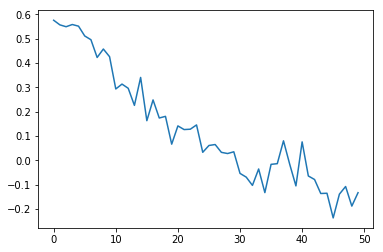

In [4]:
plt.plot(triplet_trained.get_model_by_name('triplet_learn').hist['train_loss'])
plt.show()

## Save pretrained model

In [5]:
(triplet_trained.get_model_by_name("triplet_learn")
                .save("/notebooks/e_illarionov/ecg_repo/model_dump/triplet_latest"))

## Test pipeline

In [9]:
triplet_test_pipeline = (ds.Pipeline()
                         .import_model('triplet_learn', triplet_trained)
                         .load(fmt="wfdb", components=["signal", "meta"])
                         .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                               fmt="csv", components="target")
                         .drop_labels(["~"])
                         .drop_short_signals(6000)
                         .get_triplets(100, 3000)
                         .signal_transpose([0, 2, 1])
                         .test_on_batch('triplet_learn')
                         .run(batch_size=300, shuffle=True, drop_last=True, n_epochs=1, prefetch=0, lazy=True))

In [10]:
res_test = (eds.test >> triplet_test_pipeline).run()

## Show loss on test

In [11]:
print(np.mean(res_test.get_model_by_name('triplet_learn').hist['val_loss']))

-0.0149825


## Predict pipeline

In [6]:
config = {'path': "/notebooks/e_illarionov/ecg_repo/model_dump/triplet_latest"}

triplet_predict_pipeline = (ds.Pipeline(config={'triplet_pretrained': config})
                            .init_model('triplet_pretrained')
                            .init_variable("prediction", init=list)
                            .load(fmt="wfdb", components=["signal", "meta"])
                            .load(src="/notebooks/data/ECG/training2017/REFERENCE.csv",
                                  fmt="csv", components="target")
                            .drop_labels(["~"])
                            .drop_short_signals(6000)
                            .get_triplets(100, 3000)
                            .signal_transpose([0, 2, 1])
                            .predict_on_batch('triplet_learn')
                            .run(batch_size=300, shuffle=False, drop_last=False, n_epochs=1, prefetch=0, lazy=True))

In [7]:
res_predict = (eds.test >> triplet_predict_pipeline).run()

In [8]:
res_predict.get_variable('prediction')

[array([[ 0.81562895,  0.63410139],
        [ 0.78873104,  0.80567229],
        [ 0.8892833 ,  0.86459625],
        [ 0.8309921 ,  0.88494325],
        [ 0.88990623,  0.77782059],
        [ 0.67712843,  0.83398789],
        [ 0.78509474,  0.85349953],
        [ 0.87872523,  0.82374907],
        [ 0.83525741,  0.76241374],
        [ 0.82350433,  0.88177329],
        [ 0.90221679,  0.92375916],
        [ 0.93359309,  0.82919568],
        [ 0.84673077,  0.84775066],
        [ 0.72150612,  0.86288255],
        [ 0.85504067,  0.88717109],
        [ 0.61845952,  0.91134167],
        [ 0.8320626 ,  0.82778335],
        [ 0.91597354,  0.91678542],
        [ 0.90204072,  0.82558787],
        [ 0.8541497 ,  0.73558027],
        [ 0.82441014,  0.79398686],
        [ 0.8799116 ,  0.85435426],
        [ 0.89977574,  0.89610636],
        [ 0.84487808,  0.76906967],
        [ 0.93759805,  0.78955191],
        [ 0.85445172,  0.66448772],
        [ 0.58068079,  0.7853989 ],
        [ 0.90820718,  0.902